<a href="https://colab.research.google.com/github/DkMaria/Fake-News-Detection/blob/main/BERT_UNDER_FN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pytorch_pretrained_bert pytorch-nlp

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# verify GPU availability
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
import torch.utils.data as data_utils
import torch.optim as optim
import gc #garbage collector for gpu memory 
from tqdm import tqdm

In [ ]:
# read csv files which contains all TRUE claims
true = pd.read_csv('/content/drive/MyDrive/true28.csv', delimiter=",")
df_true = pd.DataFrame(true, columns=['headline', 'text', 'keywords', 'datePublished', 'ratingName'])
print('TRUE: ', df_true)
print(len(df_true)) # 4448
print(df_true.head())

# read csv files which contains all FALSE claims
false = pd.read_csv('/content/drive/MyDrive/false05.csv', delimiter=",", encoding='mac_roman')
df_false = pd.DataFrame(false, columns=['headline', 'text', 'keywords', 'datePublished', 'ratingName'])
print('FALSE: ', df_false)
print(len(df_false)) # 
print(df_false.head())

df_true['label'] = 0
df_false['label'] = 1
data = pd.concat([df_true, df_false])
labels = data['label']

# shuffle the dataset
data = data.sample(frac=1)

target = data['label'].values

TRUE:                                                 headline  ... ratingName
0                   Fiorina: Trump's abortion flip-flop  ...       True
1     Sean Hannity says Barack Obama's jobs bill cre...  ...       True
2                          ""Executive"" makes it right  ...       True
3                 Chase Bank Won’t Allow Cash Deposits?  ...       True
4                            Shackelford Prayer Request  ...       True
...                                                 ...  ...        ...
4108                                        Moose Story  ...       True
4109  Rand Paul says federal spending has risen to 2...  ...       True
4110                                    Vieques Closure  ...       True
4111          DeKalb CEO says he wields a big budget ax  ...       True
4112               Dewitos: Doritos Flavor Mountain Dew  ...       True

[4113 rows x 5 columns]
4113
                                            headline  ... ratingName
0                Fiorina: Trum

Counter({False: 10000, True: 4113})
true 0: (4113, 6)
false 1: (10000, 6)
total class of 1 and 0: 1    4113
0    4113
Name: label, dtype: int64


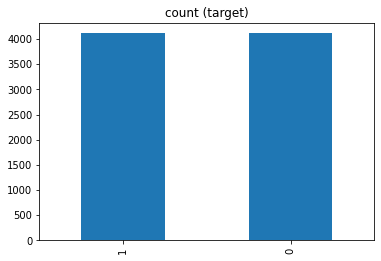

In [ ]:
from collections import Counter
print(Counter(data['ratingName'].values))

# class count
true_count, false_count = data['label'].value_counts()

# Separate class
true = data[data['label'] == 0] #true claims
false = data[data['label'] == 1]# print the shape of the class #false claims
print('true 0:', true.shape)
print('false 1:', false.shape)


'''Undersampling can be defined as removing some observations of the majority class. This is done until the majority and 
minority class is balanced out'''
false_under = false.sample(false_count)
#print(class_1_under)

test_under = pd.concat([false_under, true], axis=0)

print("total class of 1 and 0:",test_under['label'].value_counts())# plot the count after under-sampeling
test_under['label'].value_counts().plot(kind='bar', title='count (target)')

In [ ]:
target = test_under['label']

data = test_under.sample(frac=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(test_under['text'], target, test_size=0.2, random_state=4)


In [ ]:
len(X_test)

In [ ]:
train_txts = X_train
train_lbels = y_train

test_txts = X_test
test_lbels = y_test

In [ ]:
pip install transformers

In [ ]:
from sklearn.metrics import classification_report
import transformers
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from pytorch_pretrained_bert import BertTokenizer

In [ ]:
# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

100%|██████████| 231508/231508 [00:00<00:00, 686439.20B/s]


In [ ]:
len(train_txts), len(train_lbels), len(test_txts), len(test_lbels)

(6580, 6580, 1646, 1646)

In [ ]:
train_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:511], train_txts))
test_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:511], test_txts))

In [ ]:
'''Convert each token in each news to an id as present in the tokenizer vocabulary. If there’s a 
   token that is not present in the vocabulary, the tokenizer will use the special [UNK] token and
   use its id'''
train_tokens_ids = list(map(tokenizer.convert_tokens_to_ids, train_tokens))
test_tokens_ids = list(map(tokenizer.convert_tokens_to_ids, test_tokens))

In [ ]:
from keras.preprocessing.sequence import pad_sequences

In [ ]:
'''we need to pad our input so it will have the same size of 512. It means that for any review that 
   is shorter than 512 tokens, we’ll add zeros to reach 512 tokens'''

train_tokens_ids = pad_sequences(train_tokens_ids, maxlen=512, truncating="post", padding="post", dtype="int")
test_tokens_ids = pad_sequences(test_tokens_ids, maxlen=512, truncating="post", padding="post", dtype="int")

In [ ]:
'''Our target variable is currently a list of 0 and 1. We’ll convert it to numpy arrays of
   booleans'''

train_y = np.array(train_lbels) 
test_y = np.array(test_lbels)

In [ ]:
type(train_y)

numpy.ndarray

In [ ]:
from pytorch_pretrained_bert import BertModel

In [ ]:
'''Create our BERT classifier which contains an ‘initialization’ method and a ‘forward’ method that 
   returns token probabilities'''
class BertBinaryClassifier(nn.Module):
    def __init__(self, dropout=0.1):
        super(BertBinaryClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-uncased')

        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, tokens, masks=None):
        _, pooled_output = self.bert(tokens, attention_mask=masks, output_all_encoded_layers=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        proba = self.sigmoid(linear_output)
        return proba

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
str(torch.cuda.memory_allocated(device)/1000000 ) + 'M'

'0.0M'

In [ ]:
bert_clf = BertBinaryClassifier()
bert_clf = bert_clf.cuda()

100%|██████████| 407873900/407873900 [00:13<00:00, 30508355.03B/s]


In [ ]:
str(torch.cuda.memory_allocated(device)/1000000 ) + 'M'

'439.065088M'

In [ ]:
x = torch.tensor(train_tokens_ids[:3]).to(device)
y, pooled = bert_clf.bert(x, output_all_encoded_layers=False)
x.shape, y.shape, pooled.shape

(torch.Size([3, 512]), torch.Size([3, 512, 768]), torch.Size([3, 768]))

In [ ]:
y, x, pooled = None, None, None
torch.cuda.empty_cache()
str(torch.cuda.memory_allocated(device)/1000000 ) + 'M'

'3568.20736M'

In [ ]:
BATCH_SIZE = 4
EPOCHS = 10

In [ ]:
'''Generate training and testing masks'''
train_masks = [[float(i > 0) for i in ii] for ii in train_tokens_ids]
test_masks = [[float(i > 0) for i in ii] for ii in test_tokens_ids]
train_masks_tensor = torch.tensor(train_masks)
test_masks_tensor = torch.tensor(test_masks)

'''Generate token tensors for training and testing'''
train_tokens_tensor = torch.tensor(train_tokens_ids)
train_y_tensor = torch.tensor(train_y.reshape(-1, 1)).float()
test_tokens_tensor = torch.tensor(test_tokens_ids)
test_y_tensor = torch.tensor(test_y.reshape(-1, 1)).float()

'''Prepare data loaders'''
train_dataset =  torch.utils.data.TensorDataset(train_tokens_tensor, train_masks_tensor, train_y_tensor)
train_sampler =  torch.utils.data.RandomSampler(train_dataset)
train_dataloader =  torch.utils.data.DataLoader(train_dataset, sampler=train_sampler, batch_size=BATCH_SIZE)
test_dataset =  torch.utils.data.TensorDataset(test_tokens_tensor, test_masks_tensor, test_y_tensor)
test_sampler =  torch.utils.data.SequentialSampler(test_dataset)
test_dataloader =  torch.utils.data.DataLoader(test_dataset, sampler=test_sampler, batch_size=BATCH_SIZE)

In [ ]:
param_optimizer = list(bert_clf.sigmoid.named_parameters()) 
optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

In [ ]:
from torch.optim import Adam

optimizer = Adam(bert_clf.parameters(), lr=3e-6)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
for epoch_num in range(EPOCHS):
    bert_clf.train()
    train_loss = 0
    for step_num, batch_data in enumerate(train_dataloader):
        token_ids, masks, labels = tuple(t.to(device) for t in batch_data)
        print(str(torch.cuda.memory_allocated(device)/1000000 ) + 'M')
        logits = bert_clf(token_ids, masks)
        
        loss_func = nn.BCELoss()

        batch_loss = loss_func(logits, labels)
        train_loss += batch_loss.item()
        
        
        bert_clf.zero_grad()
        batch_loss.backward()
        

        #clip_grad_norm_(parameters=bert_clf.parameters(), max_norm=1.0)
        optimizer.step()
        
        #clear_output(wait=True)
        print('Epoch: ', epoch_num + 1)
        print("\r" + "{0}/{1} loss: {2} ".format(step_num, len(X_train) / BATCH_SIZE, train_loss / (step_num + 1)))

In [ ]:
bert_clf.eval()
bert_predicted = []
all_logits = []
with torch.no_grad():
    for step_num, batch_data in enumerate(test_dataloader):

        token_ids, masks, labels = tuple(t.to(device) for t in batch_data)

        logits = bert_clf(token_ids, masks)
        loss_func = nn.BCELoss()
        loss = loss_func(logits, labels)
        numpy_logits = logits.cpu().detach().numpy()
        
        bert_predicted += list(numpy_logits[:, 0] > 0.5)
        all_logits += list(numpy_logits[:, 0])

In [ ]:
np.mean(bert_predicted)

0.3784933171324423

In [ ]:
print(classification_report(test_y, bert_predicted))

              precision    recall  f1-score   support

           0       0.71      0.85      0.78       862
           1       0.79      0.63      0.70       784

    accuracy                           0.74      1646
   macro avg       0.75      0.74      0.74      1646
weighted avg       0.75      0.74      0.74      1646

